In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testdata/test.csv
/kaggle/input/traindata/train.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

data = pd.read_csv('/kaggle/input/traindata/train.csv')
test = pd.read_csv("/kaggle/input/testdata/test.csv")

In [3]:
data.isna().sum()

Location                     0
Cross_Street             16552
Latitude                     0
Longitude                    0
Date_Reported                0
Date_Occurred                0
Time_Occurred                0
Area_ID                      0
Area_Name                    0
Reporting_District_no        0
Part 1-2                     0
Modus_Operandi            2741
Victim_Age                   0
Victim_Sex                2624
Victim_Descent            2624
Premise_Code                 0
Premise_Description          5
Weapon_Used_Code         12665
Weapon_Description       12665
Status                       0
Status_Description           0
Crime_Category               0
dtype: int64

In [4]:
data['Modus_Operandi'].nunique()

10489

In [5]:
negative_age_count = data[data['Victim_Age'] < 0]['Victim_Age'].count()
print("Number of negative values in Victim_Age:", negative_age_count)

Number of negative values in Victim_Age: 6


In [6]:
data['Victim_Age'] = data['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
test['Victim_Age'] = test['Victim_Age'].apply(lambda x: 0 if x < 0 else x)
#Drop rows if latitude and longitude are 0
lat_long_zero = data[(data['Latitude'] == 0) & (data['Longitude']==0)].index
lat_long_zero_t = test[(test['Latitude'] == 0) & (test['Longitude']==0)].index
data.drop(lat_long_zero, inplace=True)
test.drop(lat_long_zero_t, inplace=True)
data.shape


(19922, 22)

In [7]:
#Remove outlier if any
Q1 = data['Victim_Age'].quantile(0.25)
Q3 = data['Victim_Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
data= data[(data['Victim_Age'] > lower_bound) & (data['Victim_Age'] < upper_bound)]

#Remove outlier if any
Q1 = test['Victim_Age'].quantile(0.25)
Q3 = test['Victim_Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 +  1.5 * IQR
test= test[(test['Victim_Age'] > lower_bound) & (test['Victim_Age'] < upper_bound)]

data.shape,test.shape

((19909, 22), (4978, 21))

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns

#data = pd.read_csv('/kaggle/input/traindata/train.csv')
#test = pd.read_csv("/kaggle/input/testdata/test.csv")

data['Cross_Street']=data['Cross_Street'].fillna("Missing")
data['Premise_Description']=data['Premise_Description'].fillna("Missing")
data['Weapon_Description']=data['Weapon_Description'].fillna("Missing")
data['Weapon_Used_Code']=data['Weapon_Used_Code'].fillna(data['Weapon_Used_Code'].mean())
data['Weapon_Description']=data['Weapon_Description'].fillna("Missing")
data['Victim_Age']=data['Victim_Age'].fillna(data['Victim_Age'].median())
data['Victim_Sex']=data['Victim_Sex'].fillna("Missing")
data['Victim_Descent']=data['Victim_Descent'].fillna("Missing")
data['Premise_Code']=data['Premise_Code'].fillna(data['Premise_Code'].mean())
data['Modus_Operandi']=data['Modus_Operandi'].fillna("Missing")

test['Cross_Street']=test['Cross_Street'].fillna("Missing")
test['Premise_Description']=test['Premise_Description'].fillna("Missing")
test['Weapon_Description']=test['Weapon_Description'].fillna("Missing")
test['Weapon_Used_Code']= test['Weapon_Used_Code'].fillna(data['Weapon_Used_Code'].mean())
test['Weapon_Description']=test['Weapon_Description'].fillna("Missing")
test['Victim_Age']=test['Victim_Age'].fillna(data['Victim_Age'].median())
test['Victim_Sex']=test['Victim_Sex'].fillna("Missing")
test['Victim_Descent']=test['Victim_Descent'].fillna("Missing")
test['Premise_Code']=test['Premise_Code'].fillna(data['Premise_Code'].mean())
test['Modus_Operandi']=test['Modus_Operandi'].fillna("Missing")


# train.csv
# Specify the date format
date_format = '%m/%d/%Y %I:%M:%S %p'  # Month/Day/Year Hour:Minute:Second AM/PM


# convert date columns to datetime with specified format
data['Date_Reported'] = pd.to_datetime(data['Date_Reported'], format=date_format)
data['Date_Occurred'] = pd.to_datetime(data['Date_Occurred'], format=date_format)

# extract year, month, day, and hour
data['Year_Reported'] = data['Date_Reported'].dt.year
data['Month_Reported'] = data['Date_Reported'].dt.month
data['Day_Reported'] = data['Date_Reported'].dt.day
data['Hour_Occurred'] = data['Time_Occurred'].apply(lambda x: int(x // 100))

# test.csv
# convert date columns to datetime with specified format
test['Date_Reported'] = pd.to_datetime(test['Date_Reported'], format=date_format)
test['Date_Occurred'] = pd.to_datetime(test['Date_Occurred'], format=date_format)

# extract year, month, day, and hour
test['Year_Reported'] = test['Date_Reported'].dt.year
test['Month_Reported'] = test['Date_Reported'].dt.month
test['Day_Reported'] = test['Date_Reported'].dt.day
test['Hour_Occurred'] = test['Time_Occurred'].apply(lambda x: int(x // 100))

# Calculate the time difference between Date_Occurred and Date_Reported
data['Time_Difference'] = (data['Date_Reported'] - data['Date_Occurred']).dt.days

# Similarly for the test data
test['Time_Difference'] = (test['Date_Reported'] - test['Date_Occurred']).dt.days

# define features and target variable for training data
X_train = data.drop(columns=['Crime_Category', 'Date_Reported', 'Date_Occurred'])
y_train = data['Crime_Category']

# prepare test data (assuming
X_test = test.drop(columns=['Date_Reported', 'Date_Occurred'])

# split the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)



categorical_features = ['Location', 'Cross_Street', 'Area_Name',  
                           'Victim_Sex', 'Victim_Descent', 'Premise_Description', 
                           'Weapon_Description', 'Status', 'Status_Description']
numerical_features = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID', 
                     'Reporting_District_no', 'Part 1-2', 'Victim_Age', 
                     'Premise_Code', 'Weapon_Used_Code','Time_Difference']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

text = 'Modus_Operandi'
text_transformer = TfidfVectorizer(stop_words='english', max_features=5000)
# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),
        ('text', text_transformer, text)
    ])





(15927, 24) (3982, 24) (15927,) (3982,)


# **EDA**

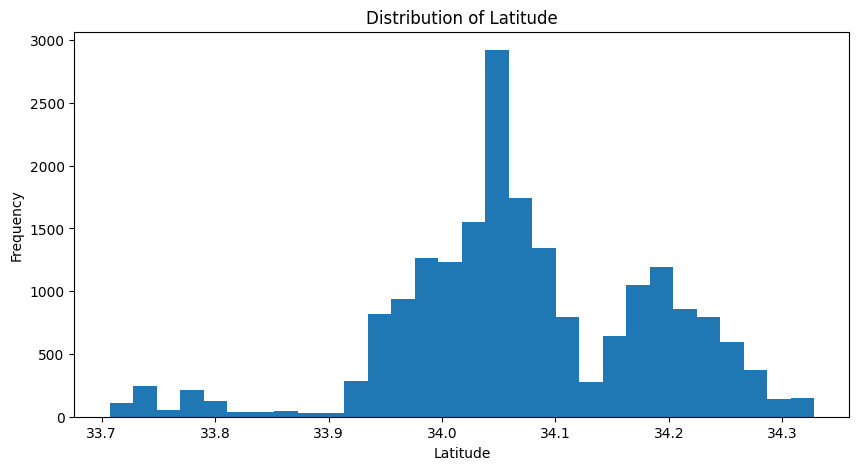

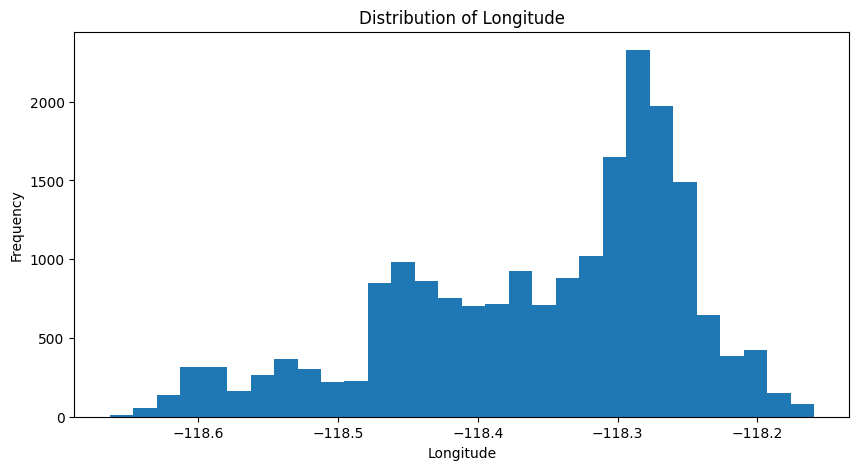

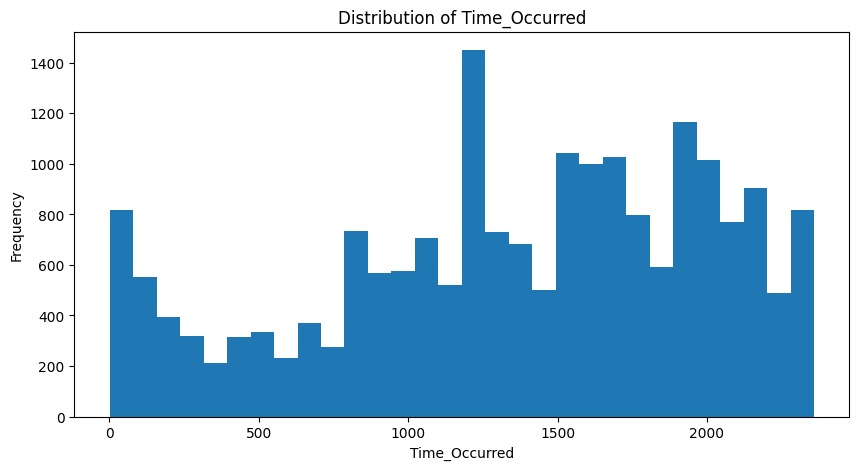

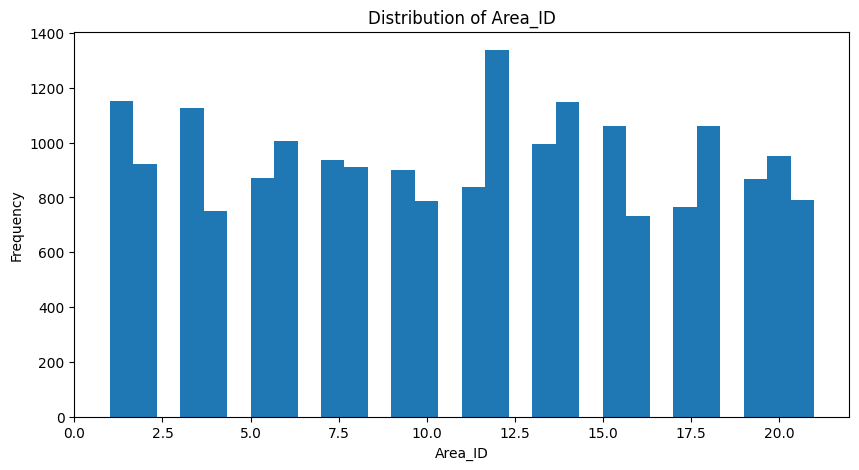

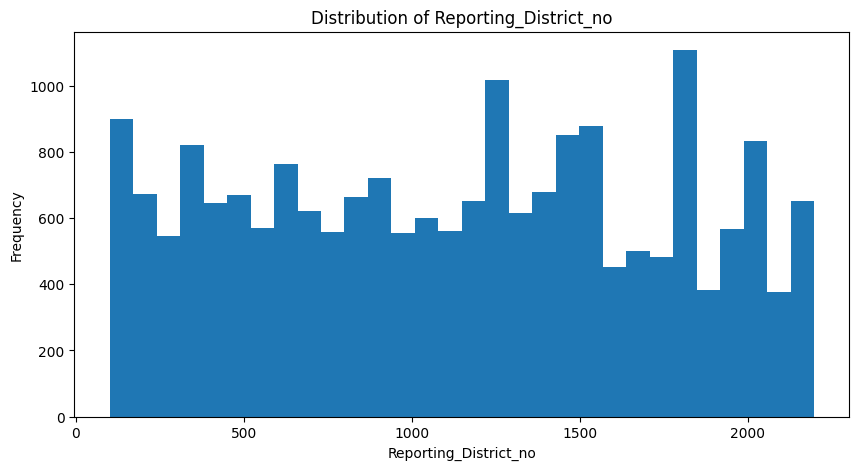

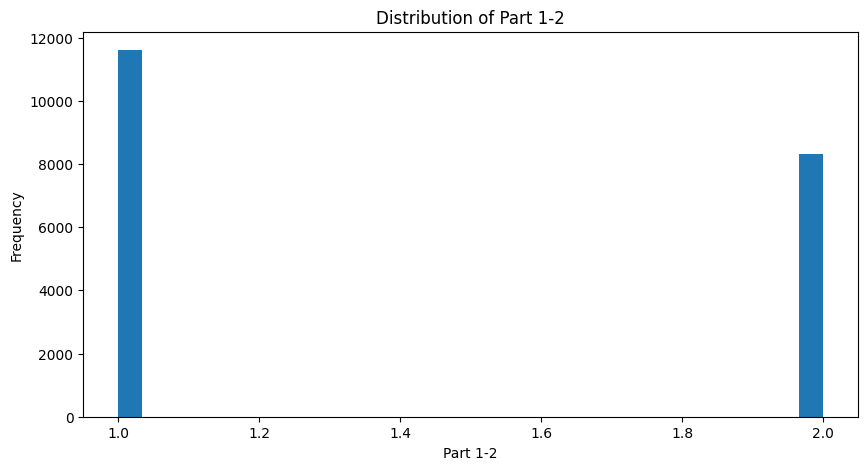

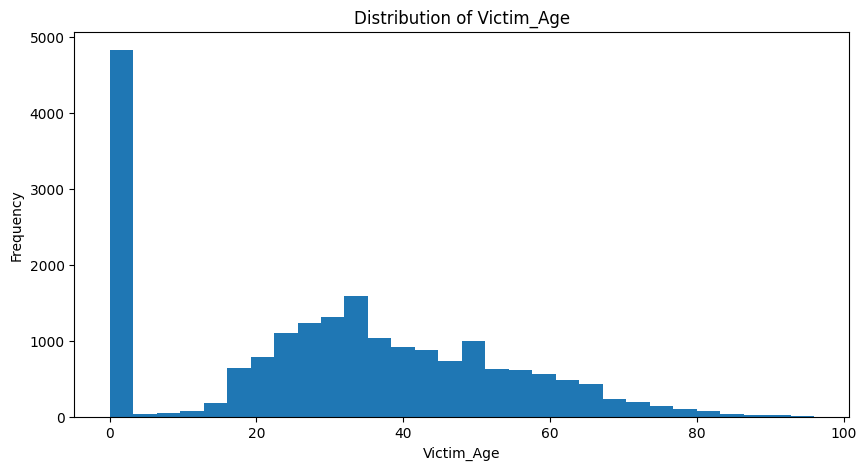

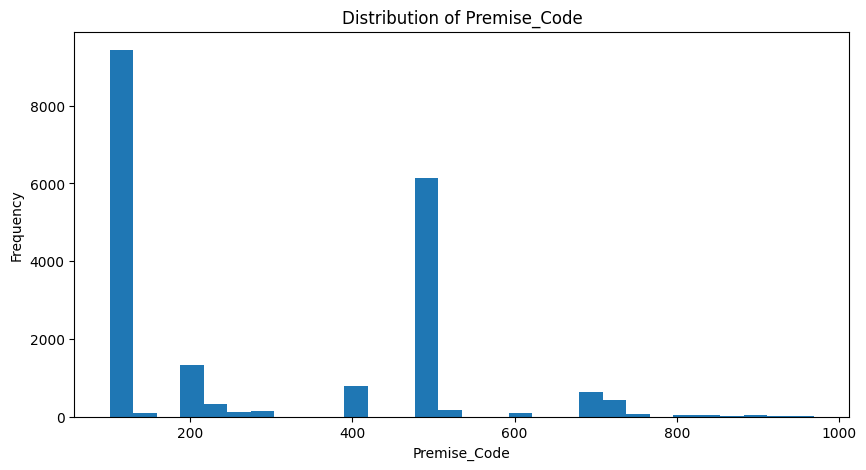

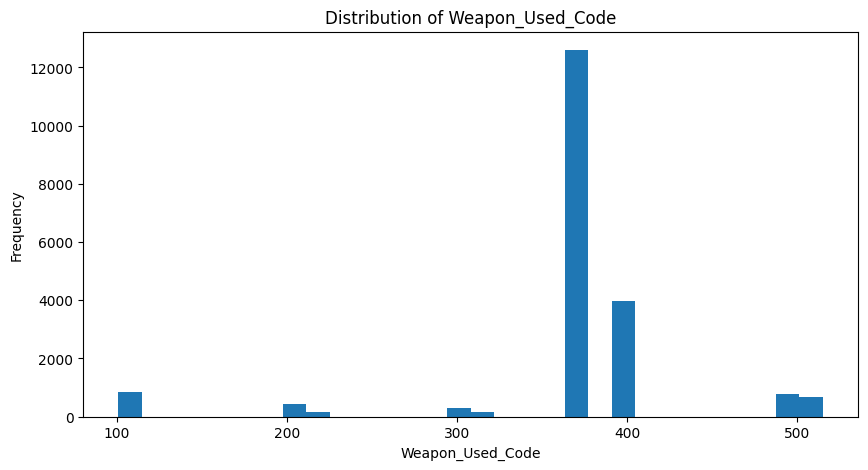

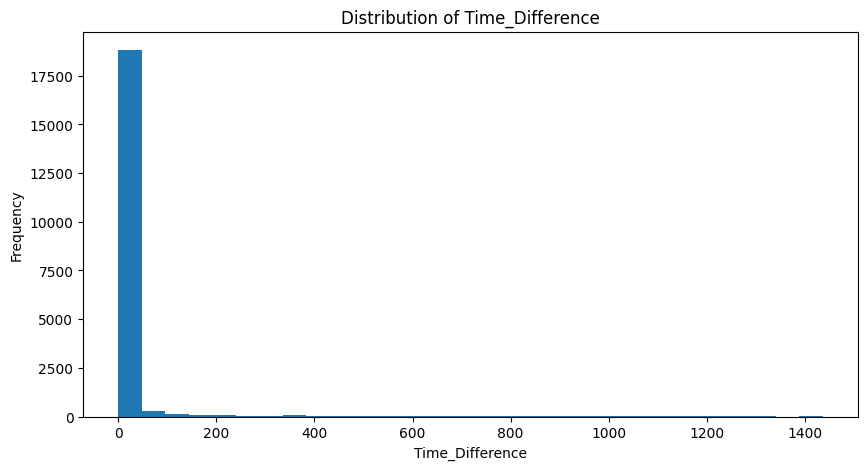

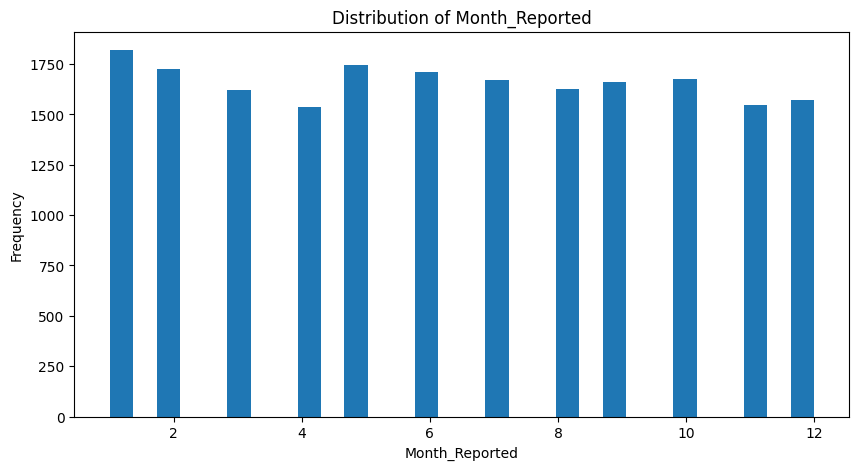

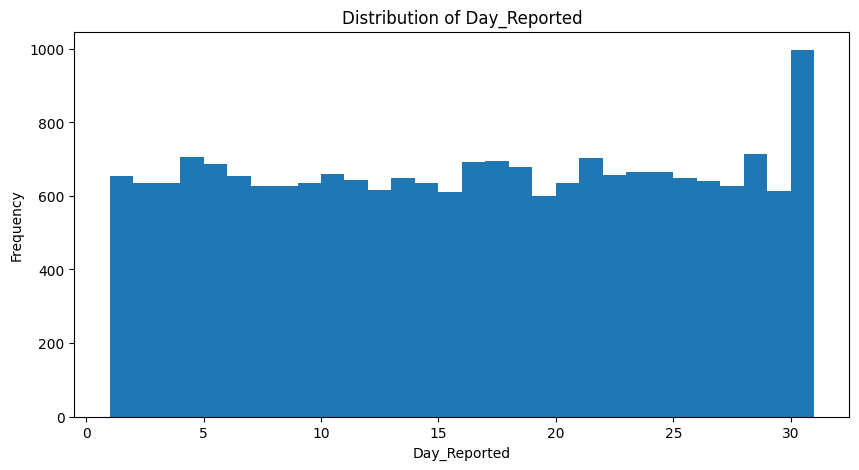

In [9]:
numerical_features_EDA=numerical_features+['Month_Reported', 'Day_Reported']
for feature in numerical_features_EDA:
    plt.figure(figsize=(10, 5))
    plt.hist(data[feature], bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

In [10]:
limited_categorical_features = [feature for feature in categorical_features if data[feature].nunique() < 500]

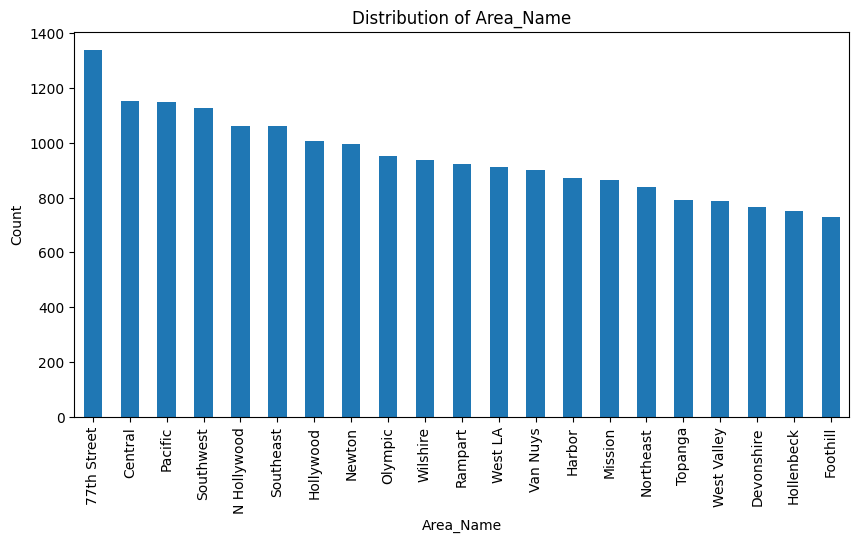

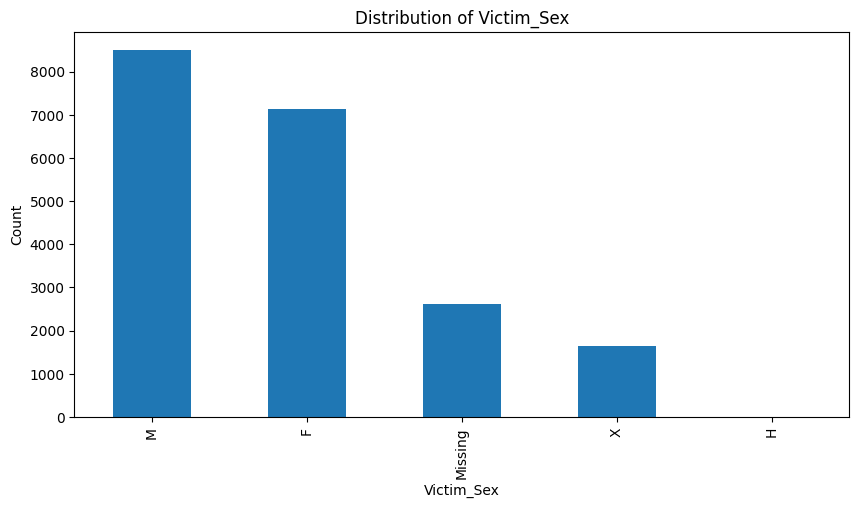

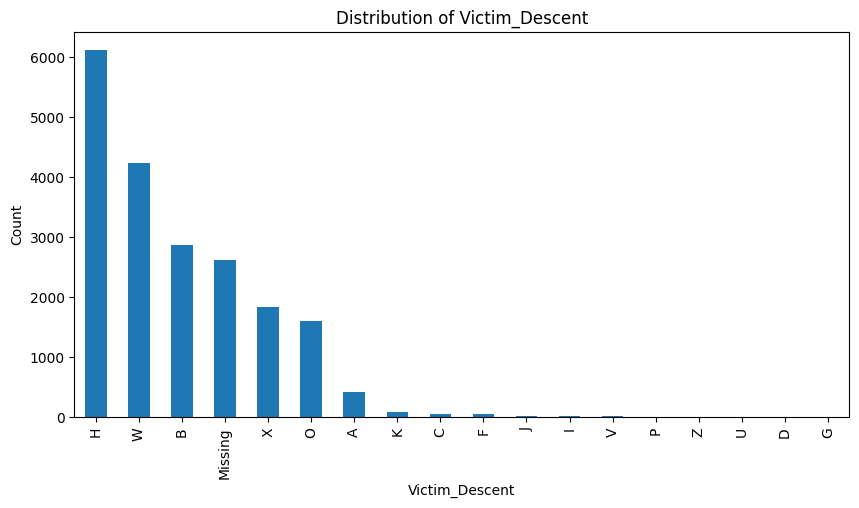

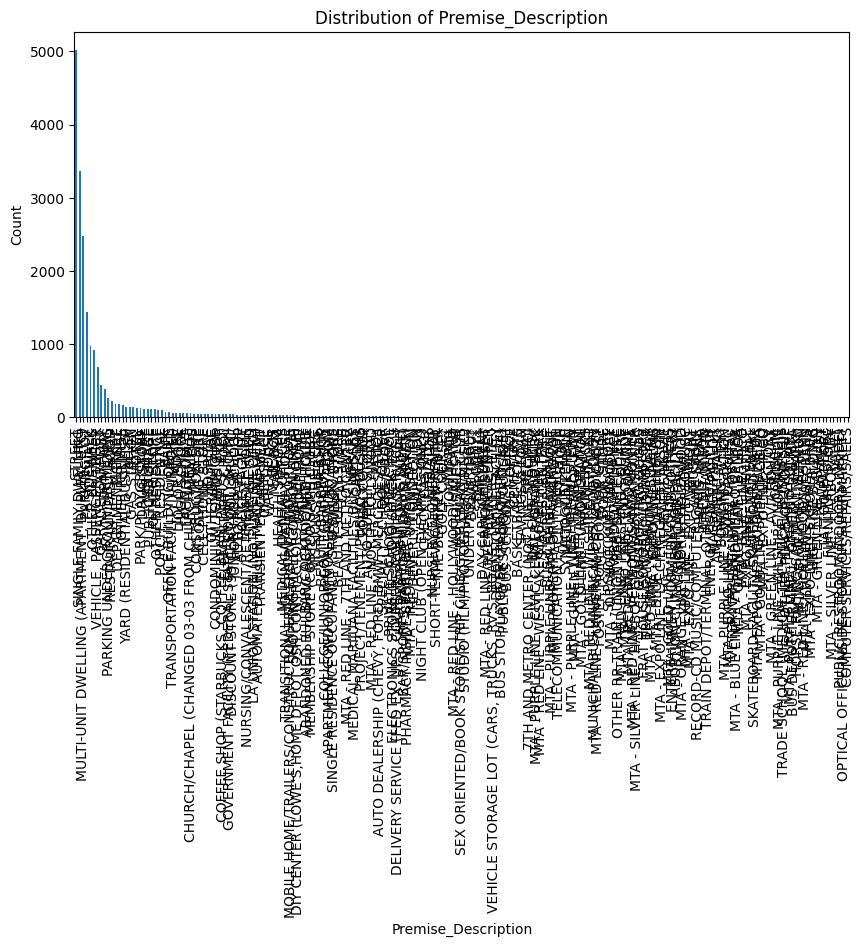

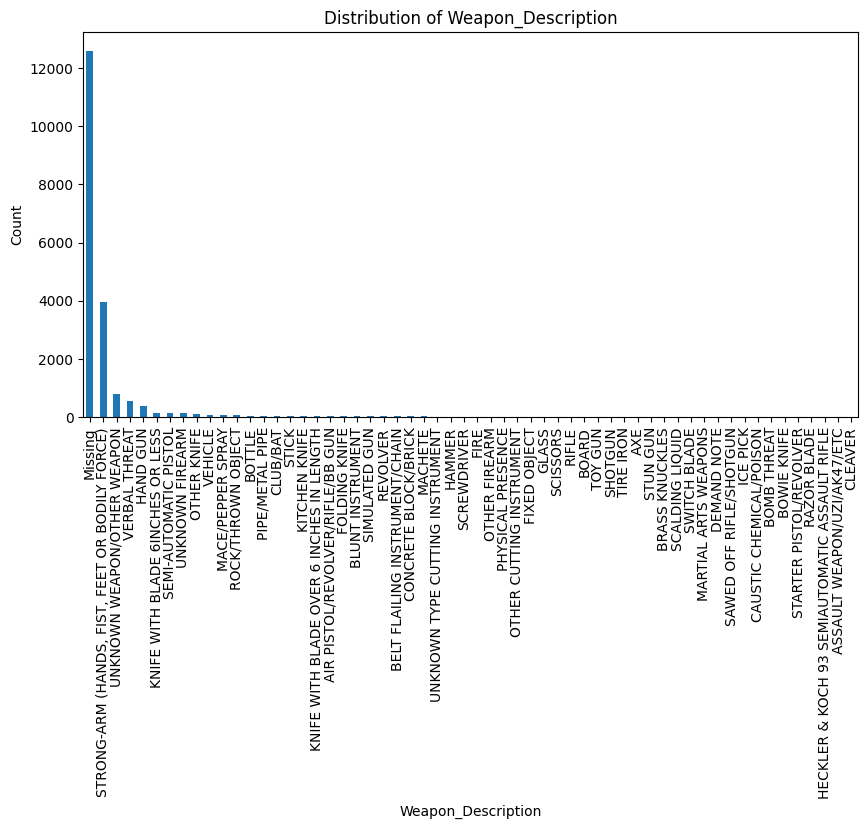

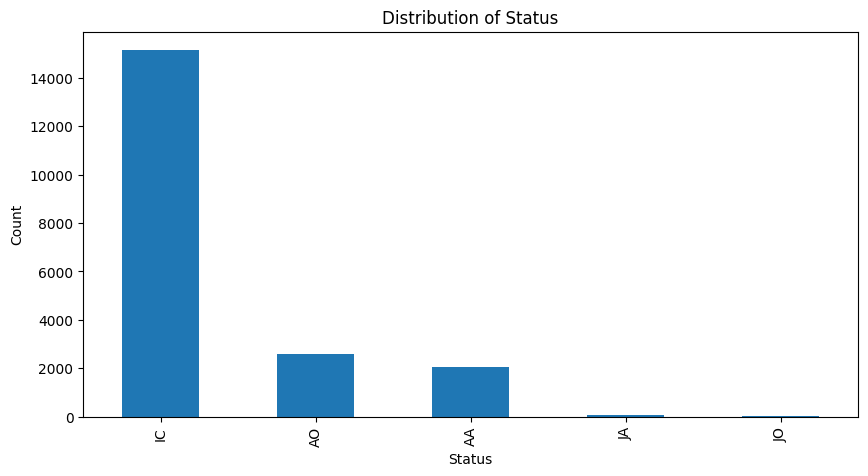

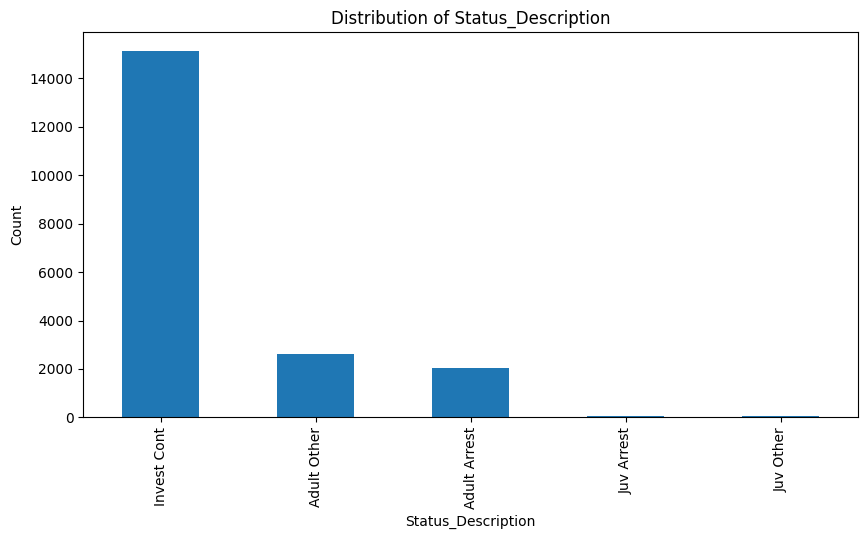

In [11]:
for feature in limited_categorical_features:
    plt.figure(figsize=(10, 5))
    data[feature].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

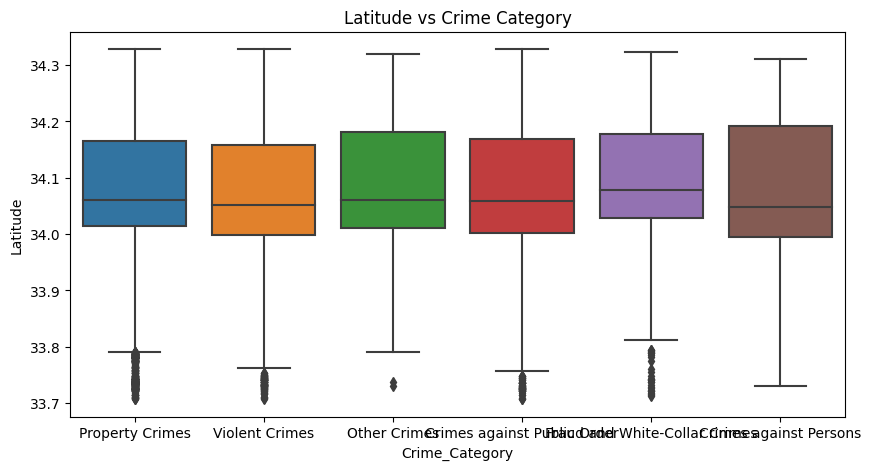

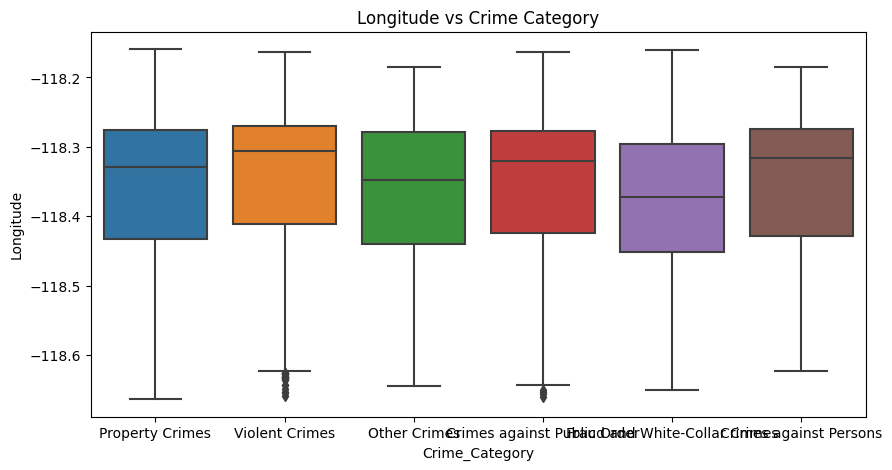

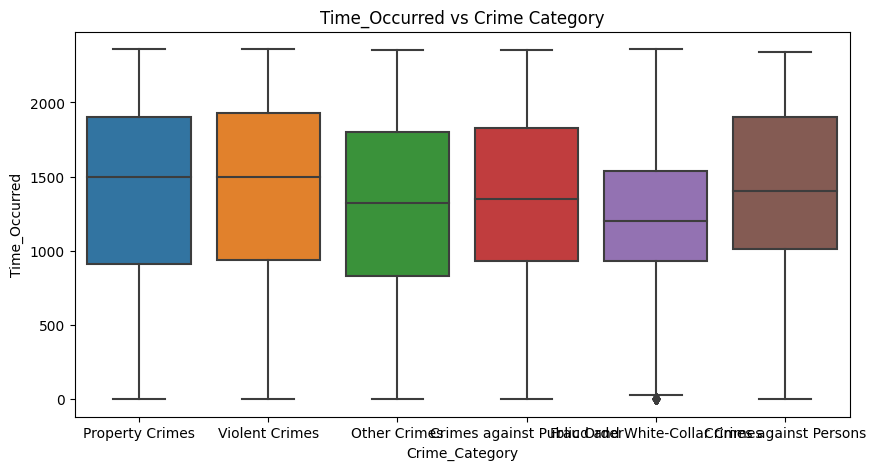

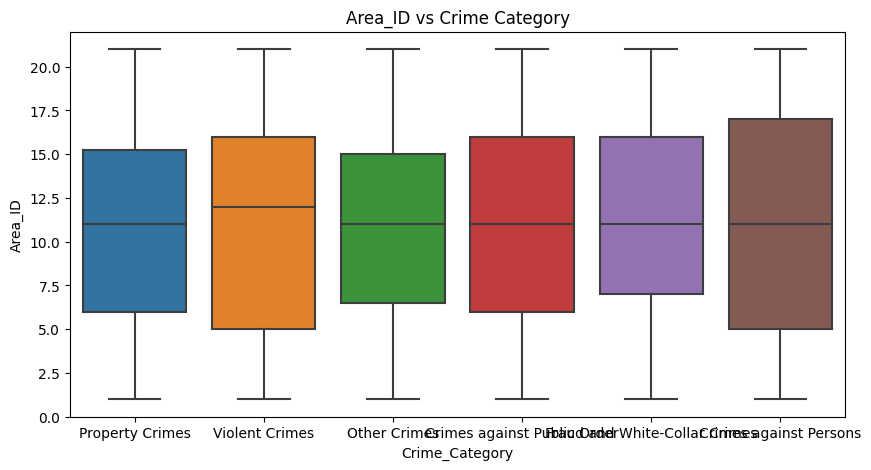

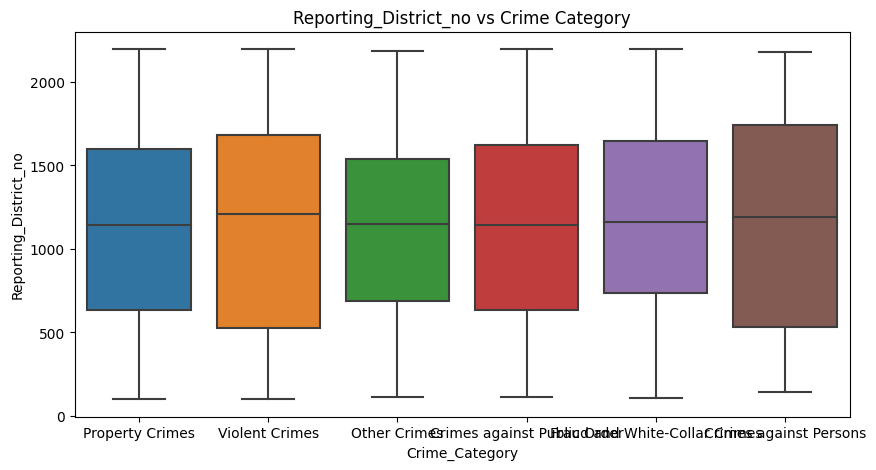

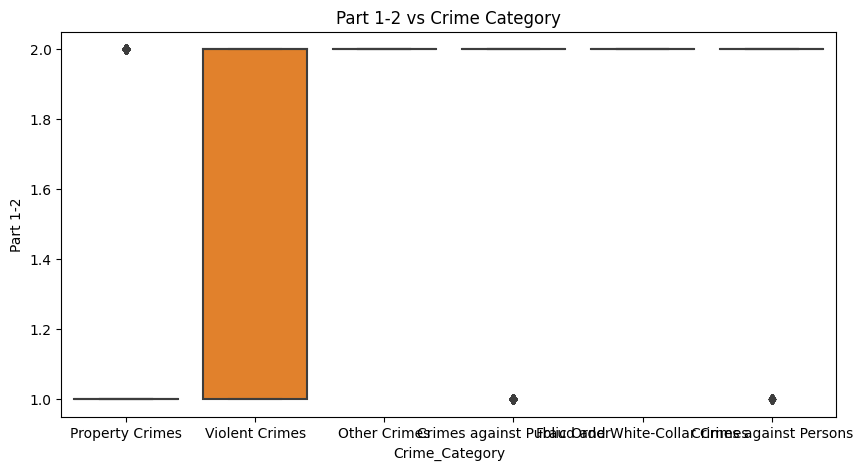

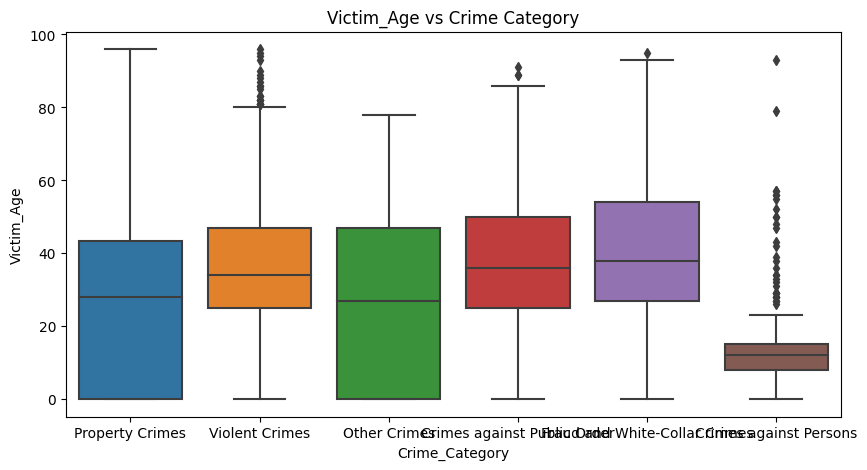

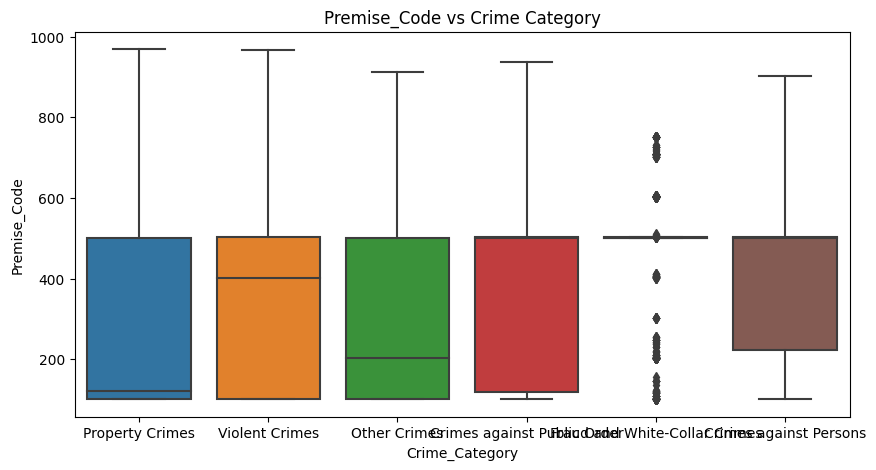

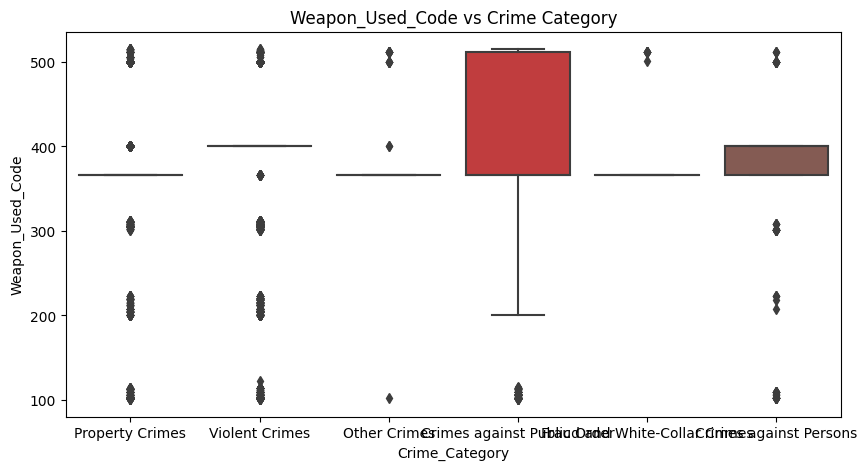

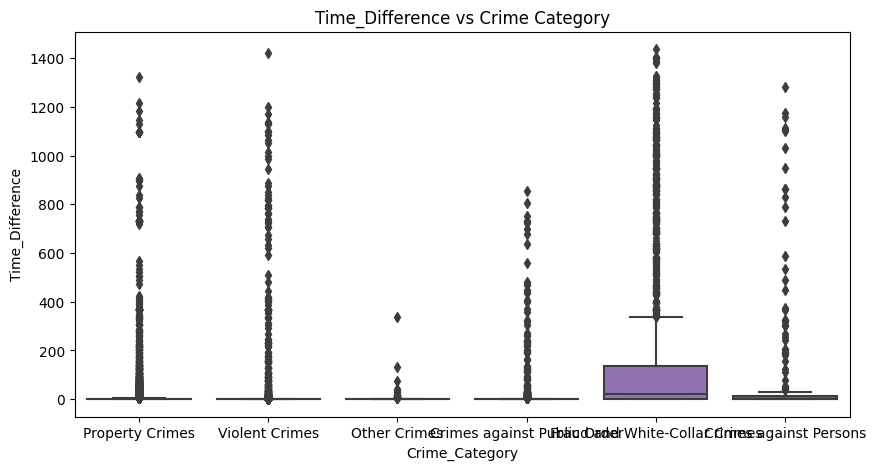

In [12]:
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Crime_Category', y=feature, data=data)
    plt.title(f"{feature} vs Crime Category")
    plt.show()

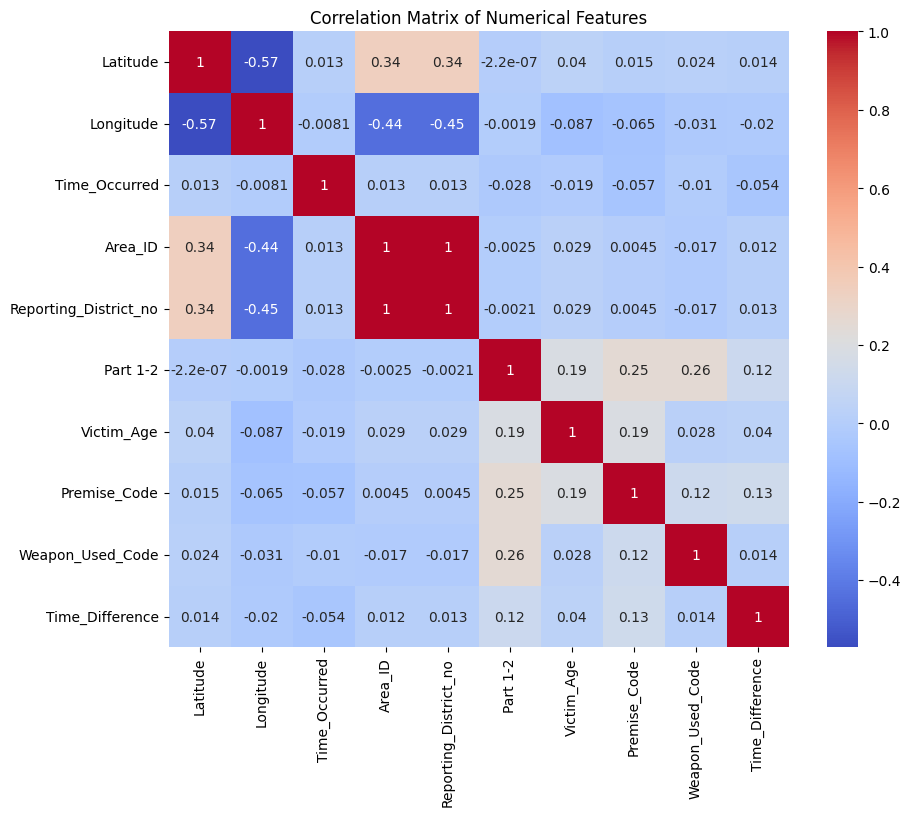

In [13]:
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

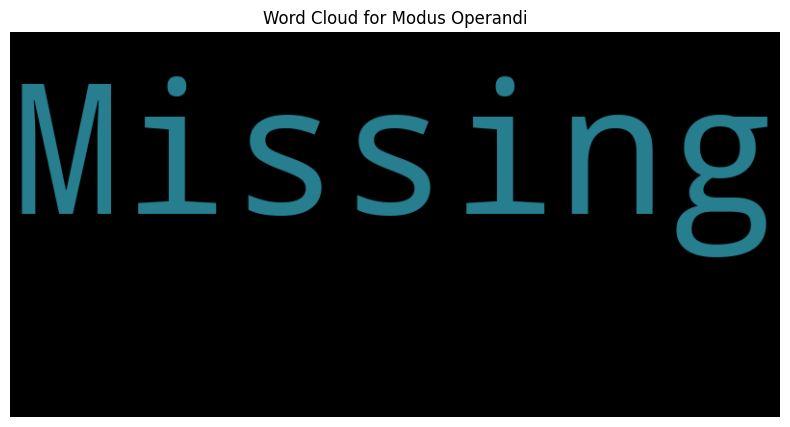

In [14]:
from wordcloud import WordCloud
text_corpus = ' '.join(data['Modus_Operandi'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400).generate(text_corpus)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Modus Operandi")
plt.show()

In [15]:
max_crime_month = data['Month_Reported'].value_counts().index[0]
print(f'max_crime_month = {max_crime_month}')

max_crime_month = 1


In [16]:
max_crime_area = data['Area_ID'].value_counts().index[0]
df_new = data.iloc[np.where(data['Area_ID']==max_crime_area)] 
print(df_new['Area_Name'].iloc[0])

max_crime_weapon = data['Weapon_Used_Code'].value_counts().index[0]
df_new = data.iloc[np.where(data['Weapon_Used_Code']==max_crime_weapon)] 
print(df_new['Weapon_Description'].iloc[0])

max_crime_day = data['Day_Reported'].value_counts().index[0]
print(f'max_crime_day_rep = {max_crime_day}')
      
max_crime_premise = data['Premise_Code'].value_counts().index[0]
df_new = data.iloc[np.where(data['Premise_Code']==max_crime_premise)] 
print(df_new['Premise_Description'].iloc[0])
      
max_crime_descent = data['Victim_Descent'].value_counts().index[0]
print(f'max_crime_descent = {max_crime_descent}')

max_crime_age = data['Victim_Age'].value_counts().index[0]
print(f'max_crime_age = {max_crime_age}')

max_crime_hour = data['Hour_Occurred'].value_counts().index[0]
print(f'max_crime_hour = {max_crime_hour}')
      
max_crime_month = data['Month_Reported'].value_counts().index[0]
print(f'max_crime_month_rep = {max_crime_month}')

77th Street
Missing
max_crime_day_rep = 28
STREET
max_crime_descent = H
max_crime_age = 0.0
max_crime_hour = 12
max_crime_month_rep = 1


In [17]:
#EDA Conclusion
#Maximum crime occurs in the area whose name is 77th Street
#In Maximum number of crime the weapon is reported missing
#Maximum crime reported around the last day of the month
#most of the crime happened on the streets
#The most crimes are committed against victims is of descent 'H'
#Victim age is unknown in most of the crime.
#Most crime reported in January
#Most crime occured at noon

# MODELS**********

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Use the best model for prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best accuracy: 0.9304958013916853


In [19]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())  # Replace with your desired model
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [20]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga', max_iter=1000, random_state=0,n_jobs=-1))  # Replace with your desired model
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

In [21]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    return accuracy, report, conf_matrix

accuracy, report, conf_matrix = evaluate_model(pipeline, X_train, y_train, X_val, y_val)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9497739829231542

Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.84      0.50      0.63        42
  Crimes against Public Order       0.85      0.87      0.86       377
Fraud and White-Collar Crimes       0.95      0.94      0.94       268
                 Other Crimes       0.69      0.28      0.40        32
              Property Crimes       0.98      0.98      0.98      2305
               Violent Crimes       0.91      0.96      0.94       958

                     accuracy                           0.95      3982
                    macro avg       0.87      0.75      0.79      3982
                 weighted avg       0.95      0.95      0.95      3982


Confusion Matrix:
 [[  21    5    0    0    0   16]
 [   0  327    8    4    9   29]
 [   0   13  251    0    4    0]
 [   0   13    5    9    4    1]
 [   1    7    1    0 2256   40]
 [   3   19    0    0   18  918]]


In [22]:
#logistic regression 94.97
#XGB 94.67
#RF 93.0

In [23]:
test_predictions = pipeline.predict(test)

# Create a submission DataFrame
submission = pd.DataFrame({"ID": range(1, len(test_predictions) + 1), "Crime_Category": test_predictions})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)